# Test against Transmit Power

/home/ahmed/DRL-Active-RIS-/network/network_env.py:323: RuntimeWarning: divide by zero encountered in scalar divide
  dist_inct = self.cfg.dist_constant / (dist_uav_uf / self.cfg.grid_lim)


Transmit Power: -10.00 dBm, Average Sum Rate: 4012.2017 bps/Hz
Transmit Power: -7.00 dBm, Average Sum Rate: 4220.7337 bps/Hz
Transmit Power: -4.00 dBm, Average Sum Rate: 4220.7337 bps/Hz
Transmit Power: -1.00 dBm, Average Sum Rate: 4220.7337 bps/Hz
Transmit Power: 2.00 dBm, Average Sum Rate: 4220.7337 bps/Hz
Transmit Power: 5.00 dBm, Average Sum Rate: 4220.7337 bps/Hz
Transmit Power: 8.00 dBm, Average Sum Rate: 4220.7337 bps/Hz
Transmit Power: 11.00 dBm, Average Sum Rate: 4220.7337 bps/Hz
Transmit Power: 14.00 dBm, Average Sum Rate: 4220.7337 bps/Hz
Transmit Power: 17.00 dBm, Average Sum Rate: 4220.7337 bps/Hz
Transmit Power: 20.00 dBm, Average Sum Rate: 4220.7337 bps/Hz


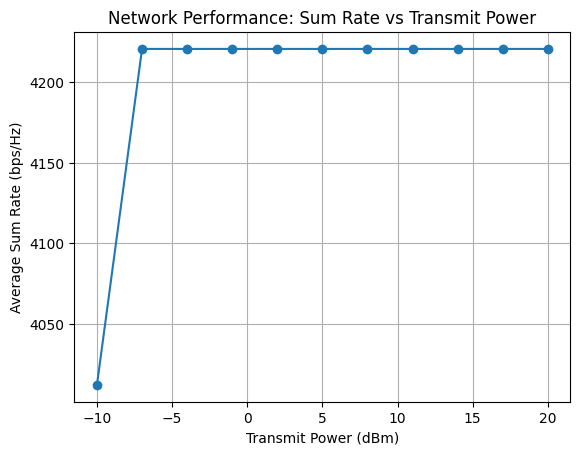

In [3]:
import numpy as np
from network_env import NetworkEnv
from sb3_plus import MultiOutputPPO
 # Assuming you're using PPO

def test_network_performance(model_path, num_episodes=10):
    # Load the trained model
    model = MultiOutputPPO.load(model_path)

    # Create the environment
    env = NetworkEnv(ris_opt=True, uav_opt=True, ma_scheme="noma")

    # Define the range of transmit powers to test (10 dBm to 20 dBm)
    transmit_powers_dbm = np.linspace(-10, 20, 11)
    
    results = []

    for power_dbm in transmit_powers_dbm:
        # Convert dBm to linear scale
        power_linear = 10 ** (power_dbm / 10) / 1000  # Convert to Watts
        
        # Set the transmit power for all base stations
        env.cfg.Pt = power_linear
        env.BS1.Pt = power_linear
        env.BS2.Pt = power_linear
        env.BS3.Pt = power_linear

        episode_sum_rates = []

        for _ in range(num_episodes):
            obs, _ = env.reset()
            episode_sum_rate = 0
            done = False
            while not done:
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                episode_sum_rate += info['sum_rate']
            
            episode_sum_rates.append(episode_sum_rate)

        avg_sum_rate = np.mean(episode_sum_rates)
        results.append((power_dbm, avg_sum_rate))

    return results

# Usage
model_path = "/home/ahmed/DRL-Active-RIS-/network/logs/MOPPO_noma_ris_uav/model.zip"
performance_results = test_network_performance(model_path)

# Print results
for power_dbm, sum_rate in performance_results:
    print(f"Transmit Power: {power_dbm:.2f} dBm, Average Sum Rate: {sum_rate:.4f} bps/Hz")

# Optional: Plot the results
import matplotlib.pyplot as plt

powers, sum_rates = zip(*performance_results)
plt.plot(powers, sum_rates, marker='o')
plt.xlabel('Transmit Power (dBm)')
plt.ylabel('Average Sum Rate (bps/Hz)')
plt.title('Network Performance: Sum Rate vs Transmit Power')
plt.grid(True)
plt.show()

/home/ahmed/DRL-Active-RIS-/network/network_env.py:323: RuntimeWarning: divide by zero encountered in scalar divide
  dist_inct = self.cfg.dist_constant / (dist_uav_uf / self.cfg.grid_lim)


Transmit Power: -10.00 dBm, Average Sum Rate: 4012.2017 bps/Hz
Transmit Power: -7.00 dBm, Average Sum Rate: 4012.2017 bps/Hz
Transmit Power: -4.00 dBm, Average Sum Rate: 4012.2017 bps/Hz
Transmit Power: -1.00 dBm, Average Sum Rate: 4012.2017 bps/Hz
Transmit Power: 2.00 dBm, Average Sum Rate: 4012.2017 bps/Hz
Transmit Power: 5.00 dBm, Average Sum Rate: 4012.2017 bps/Hz
Transmit Power: 8.00 dBm, Average Sum Rate: 4012.2017 bps/Hz
Transmit Power: 11.00 dBm, Average Sum Rate: 4012.2017 bps/Hz
Transmit Power: 14.00 dBm, Average Sum Rate: 4012.2017 bps/Hz
Transmit Power: 17.00 dBm, Average Sum Rate: 4012.2017 bps/Hz
Transmit Power: 20.00 dBm, Average Sum Rate: 4012.2017 bps/Hz


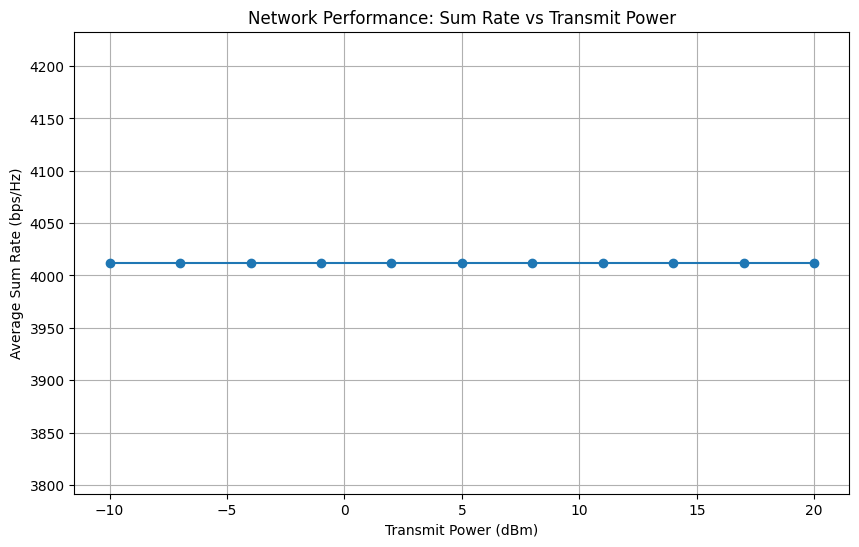

In [5]:
import numpy as np
from network_env import NetworkEnv
from sb3_plus import MultiOutputPPO
from utils import init_links, update_links
def test_network_performance(model_path, num_episodes=10):
    # Load the trained model
    model = MultiOutputPPO.load(model_path)

    # Define the range of transmit powers to test (-10 dBm to 20 dBm)
    transmit_powers_dbm = np.linspace(-10, 20, 11)
    
    results = []

    for power_dbm in transmit_powers_dbm:
        # Convert dBm to linear scale
        power_linear = 10 ** (power_dbm / 10) / 1000  # Convert to Watts
        
        # Create a new environment for each power level
        env = NetworkEnv(ris_opt=True, uav_opt=True, ma_scheme="noma")
        
        # Set the transmit power for all base stations
        env.cfg.Pt = power_linear
        env.BS1.Pt = power_linear
        env.BS2.Pt = power_linear
        env.BS3.Pt = power_linear

        # Update the links and channels with the new power
        env._init_network()
        env.links = init_links(
            env.cfg,
            env.BS1,
            env.BS2,
            env.BS3,
            env.aRIS,
            env.tRIS,
            env.U_c,
            env.U_nc,
            env.U_f,
        )
        update_links(env.links, ex_pathloss=True, ex_rvs=True)

        episode_sum_rates = []

        for _ in range(num_episodes):
            obs, _ = env.reset()
            episode_sum_rate = 0
            done = False
            while not done:
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                episode_sum_rate += info['sum_rate']
            
            episode_sum_rates.append(episode_sum_rate)

        avg_sum_rate = np.mean(episode_sum_rates)
        results.append((power_dbm, avg_sum_rate))

    return results

# Usage
model_path = "/home/ahmed/DRL-Active-RIS-/network/logs/MOPPO_noma_ris_uav/model.zip"
performance_results = test_network_performance(model_path)

# Print results
for power_dbm, sum_rate in performance_results:
    print(f"Transmit Power: {power_dbm:.2f} dBm, Average Sum Rate: {sum_rate:.4f} bps/Hz")

# Plot the results
import matplotlib.pyplot as plt

powers, sum_rates = zip(*performance_results)
plt.figure(figsize=(10, 6))
plt.plot(powers, sum_rates, marker='o')
plt.xlabel('Transmit Power (dBm)')
plt.ylabel('Average Sum Rate (bps/Hz)')
plt.title('Network Performance: Sum Rate vs Transmit Power')
plt.grid(True)
plt.show()

In [7]:
import numpy as np
from network_env import NetworkEnv
from sb3_plus import MultiOutputPPO
from utils import init_links, update_links

def test_ris_elements_performance(model_path, num_episodes=100):
    # Load the trained model
    model = MultiOutputPPO.load(model_path)

    # Set the number of RIS elements
    n_elements = 120
    
    # Create a new environment with 120 RIS elements
    env = NetworkEnv(ris_opt=True, uav_opt=True, ma_scheme="noma")
    
    # Set the number of RIS elements (should already be 120, but just to be sure)
    env.cfg.n_elements = n_elements
    env.aRIS.n_elements = n_elements
    env.tRIS.n_elements = n_elements

    # Reinitialize the network
    env._init_network()
    env.links = init_links(
        env.cfg,
        env.BS1,
        env.BS2,
        env.BS3,
        env.aRIS,
        env.tRIS,
        env.U_c,
        env.U_nc,
        env.U_f,
    )
    update_links(env.links, ex_pathloss=True, ex_rvs=True)

    episode_sum_rates = []

    for _ in range(num_episodes):
        obs, _ = env.reset()
        episode_sum_rate = 0
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_sum_rate += info['sum_rate']
        
        episode_sum_rates.append(episode_sum_rate)

    avg_sum_rate = np.mean(episode_sum_rates)
    std_sum_rate = np.std(episode_sum_rates)

    return avg_sum_rate, std_sum_rate

# Usage
model_path = "/home/ahmed/DRL-Active-RIS-/network/logs/MOPPO_noma_ris_uav/model.zip"
avg_sum_rate, std_sum_rate = test_ris_elements_performance(model_path)

print(f"Number of RIS Elements: 120")
print(f"Average Sum Rate: {avg_sum_rate:.4f} bps/Hz")
print(f"Standard Deviation: {std_sum_rate:.4f} bps/Hz")

AttributeError: can't set attribute 'n_elements'

In [10]:
import numpy as np
from network_env import NetworkEnv
from sb3_plus import MultiOutputPPO
from utils import init_links, update_links
import gymnasium as gym
from comyx.network import RIS  # Import the RIS class
from config import *
cfg = get_cfg()

def test_ris_elements_performance(model_path, num_episodes=100, n_elements=120):
    # Load the trained model
    model = MultiOutputPPO.load(model_path)
    
    # Create a new environment
    env = NetworkEnv(ris_opt=True, uav_opt=True, ma_scheme="noma")
    
    # Update the number of RIS elements in the configuration
    env.cfg.n_elements = n_elements
    
    # Recreate RIS objects with the new number of elements
    env.aRIS = RIS("UAV", n_elements, position=env.cfg.init_ris_pos)
    env.tRIS = RIS("tRIS", n_elements, position=env.cfg.tris_loc)

    # Reinitialize the network
    env._init_network()
    env.links = init_links(
        env.cfg,
        env.BS1,
        env.BS2,
        env.BS3,
        env.aRIS,
        env.tRIS,
        env.U_c,
        env.U_nc,
        env.U_f,
    )
    update_links(env.links, ex_pathloss=True, ex_rvs=True)

    # Update the action space for the new number of RIS elements
    env.action_space['aris'] = gym.spaces.Box(
        low=-1, high=1, shape=(n_elements,), dtype=np.float32
    )
    env.action_space['tris'] = gym.spaces.Box(
        low=-1, high=1, shape=(n_elements,), dtype=np.float32
    )

    episode_sum_rates = []

    for _ in range(num_episodes):
        obs, _ = env.reset()
        episode_sum_rate = 0
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_sum_rate += info['sum_rate']
        
        episode_sum_rates.append(episode_sum_rate)

    avg_sum_rate = np.mean(episode_sum_rates)
    std_sum_rate = np.std(episode_sum_rates)

    return avg_sum_rate, std_sum_rate

# Usage
model_path = "/home/ahmed/DRL-Active-RIS-/network/logs/MOPPO_noma_ris_uav/model.zip"
avg_sum_rate, std_sum_rate = test_ris_elements_performance(model_path, n_elements=120)

print(f"Number of RIS Elements:", cfg.n_elements)
print(f"Average Sum Rate: {avg_sum_rate:.4f} bps/Hz")
print(f"Standard Deviation: {std_sum_rate:.4f} bps/Hz")

Number of RIS Elements: 120
Average Sum Rate: 4199.8805 bps/Hz
Standard Deviation: 207.4867 bps/Hz


In [1]:
def test_ris_elements_performance(model_path, num_episodes=100):
    # Load the trained model
    model = MultiOutputPPO.load(model_path)
    
    # Create a new environment with the updated config
    env = NetworkEnv(cfg=cfg, ris_opt=True, uav_opt=True, ma_scheme="noma")
    
    # The number of RIS elements is now taken from cfg
    n_elements = cfg.n_elements

    # No need to update env.cfg.n_elements or recreate RIS objects
    # as they should already be correct from the environment initialization

    # Update the action space for the new number of RIS elements
    env.action_space['aris'] = gym.spaces.Box(
        low=-1, high=1, shape=(n_elements,), dtype=np.float32
    )
    env.action_space['tris'] = gym.spaces.Box(
        low=-1, high=1, shape=(n_elements,), dtype=np.float32
    )

    episode_sum_rates = []

    for _ in range(num_episodes):
        obs, _ = env.reset()
        episode_sum_rate = 0
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            # Truncate the action to match the new number of elements
            action['aris'] = action['aris'][:n_elements]
            action['tris'] = action['tris'][:n_elements]
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode_sum_rate += info['sum_rate']
        
        episode_sum_rates.append(episode_sum_rate)

    avg_sum_rate = np.mean(episode_sum_rates)
    std_sum_rate = np.std(episode_sum_rates)

    return avg_sum_rate, std_sum_rate

# Usage
model_path = "/home/ahmed/DRL-Active-RIS-/network/logs/MOPPO_noma_ris_uav/model.zip"
avg_sum_rate, std_sum_rate = test_ris_elements_performance(model_path)

print(f"Number of RIS Elements: {cfg.n_elements}")
print(f"Average Sum Rate: {avg_sum_rate:.4f} bps/Hz")
print(f"Standard Deviation: {std_sum_rate:.4f} bps/Hz")

ValueError: cannot reshape array of size 24000 into shape (30,1,200)